<center>  <h1> Lecture 3: Differentiable Modules and Minibatching SOLUTIONS </h1> </center> 
<center> Jillian Fisher, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2023), University of Washington </center>
    <center>  </center>
    
This notebook is inspired by the [D2L book](https://d2l.ai/) and adapted from lecture material created by Krishna Pillutla.

Today we studied two concepts:

- Writing differentiable modules in PyTorch, and, 
- Minibatching for stochastic gradient optimization.


## 1. Differentiable Modules and Functions
We will refer to differentiable programming as DiffProg in short. 

It is important to make a distinction between three types of objects: a mathematical function, a DiffProg function and a differentiable module. 

<img src="https://homes.cs.washington.edu/~pillutla/public/figures/function_math_code.jpeg" width="1200">

- **A mathematical function** is an object $f: \mathbb{R}^{d_1} \to \mathbb{R}^{d_2}$, for instance,
$$
    f(x) = \exp(x) - \sin(x) \,.
$$

- **A DiffProg function** is a piece of code which implements a mathematical function $f: \mathbb{R}^n \to \mathbb{R}^m$ as a program such that: 
    1. $f$ is differentiable (in the [mathematical sense](https://en.wikipedia.org/wiki/Differentiable_function)); this allows computation of derivatives of the output with respect to *each* of the inputs, 
    2. the partial derivatives of $f$ are either computable by automatic differentiation or are explicitly implemented, and, 
    3. the program maintains no *state*
    
- **A differentiable module** is a piece of code which implements a mathematical function $f: \mathbb{R}^{n_1} \times \mathbb{R}^{n_2} \to \mathbb{R}^m$ as a program such that: 
    1. $f$ is differentiable (in the [mathematical sense](https://en.wikipedia.org/wiki/Differentiable_function)); this allows computation of derivatives of the output with respect to *each* of the inputs, 
    2. the partial derivatives of $f$ are either computable by automatic differentiation or are explicitly implemented, and, 
    3. the program is allowed to maintain some parameters as *state*. In other words, it is implemented as a *class*, not a pure *function*.

**Recall: state of a program:** 
A program is called stateful if it is designed to remember preceding events or user interactions the remembered information is called the state of the system ([Wikipedia link](https://en.wikipedia.org/wiki/State_(computer_science))). 
Pure functions are stateless, while classes are generally stateful because the members of a class can influence its outcome (see `self.name` below). Classes also allow *static* methods that are stateless. More on this below. 
To refresh your memory on object oriented programming in Python, please consult [this tutorial](https://realpython.com/python3-object-oriented-programming/).

In our context, the state of differentiable modules is made up of its *parameters*.

<img src="https://homes.cs.washington.edu/~pillutla/public/figures/module.jpeg" width="400">


We now distinguish between the inputs and parameters of a mathematical function, similar to a module.
We write $f(x; \theta)$, where the semi-colon separates the input $x$ from the parameters $\theta$. 
Two examples of mathematical functions which we have already coded up include:

- Affine functions: $f(x; \theta) = W^\top x + b$, where $W \in \mathbb{R}^{d_1 \times d_2}$ and $b \in \mathbb{R}^{d_2}$ are the parameters, i.e., $\theta = (W, b)$. 


- Nonlinear functions: $f(x; \theta) = \big(\sigma(x_1), \cdots, \sigma(x_{d_1})\big)$ is a non-linear function $\sigma$, such as the rectified linear unit (ReLU) applied element-wise. This module has no parameters, i.e., $\theta = \varnothing$. 


**Programming Aspects**: First note that the data-types of inputs, parameters and outputs should be a floating type such as `float32` or `float64`. 


In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/__/vmn4s2rd6755rfl9h22x7pzr0000gn/T/ipykernel_3983/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Part 1: Functions versus Modules

The difference between DiffProg functions and modules is analogous to the difference between functional programming and object-oriented programming. 

In PyTorch, we implement the module is implemented by a regular class, which can maintain a state (member variables); the state can be modified by *instance methods*. However, we implement a DiffProg function as a class with static methods only, which is effectively just a function without state. The difference between these two is excellently explained [in this article](https://realpython.com/instance-class-and-static-methods-demystified/).

In the first exercise, we will understand the underlying programming concepts. 

**Exercise:** Consider the following class. Which of the commands listed below are valid?

In [1]:
class MyClass:
    def __init__(self, name):
        self.name = name
        
    def method(self, arg):
        print(f'instance method called, arg: {arg}, object name: {self.name}, object: {self}')

    @staticmethod
    def staticmethod_1(arg):
        print(f'static method called, arg: {arg}. No object, no name')
        
    @staticmethod
    def staticmethod_2(arg):
        print(f'static method called, arg: {arg}. object name: {self.name}')

my_object = MyClass('Potato')  # an object is an instance of a class

# TODO: which of these are valid? Why?
my_object.method(1) 
my_object.staticmethod_1(2)
# my_object.staticmethod_2(3)
# MyClass.method(4)
MyClass.staticmethod_1(5)
# MyClass.staticmethod_2(6)

instance method called, arg: 1, object name: Potato, object: <__main__.MyClass object at 0x7fdb386c6e80>
static method called, arg: 2. No object, no name
static method called, arg: 5. No object, no name


When we write a DiffProg function, we use static methods only. 
On the other hand, we write modules as instance methods. Are the following statements valid?

Yes! They are all valid.

In [2]:
my_object = MyClass('Yam')  # an object is an instance of a class

my_object.method(25)

my_object.name = 'Cassava'

my_object.method(50)


instance method called, arg: 25, object name: Yam, object: <__main__.MyClass object at 0x7fdb386c60d0>
instance method called, arg: 50, object name: Cassava, object: <__main__.MyClass object at 0x7fdb386c60d0>


Did you notice how we changed the `name` of the same object? 
The `name` field can be considered as a state. It exists outside of function calls.

**Caution:** One must be careful while working with instance methods in objects. 
The state of the object may be altered without us noticing it.
This is especially true in complex programs 
such as the statistical and numerical ones we consider in this course. 
Unintended changes to state could lead to countless hours of debugging.

## Part 2: When is it beneficial to hard-code derivatives?

Recall that computing the derivatives with automatic differentiation 
is as efficient (or inefficient) as the implementation of the function (a.k.a. the forward pass). 

We will consider an example where we can speed up the derivative calculations by orders of magnitude. 

We first start by recalling the mechanics of `torch.autograd.Function`. 

Consider a function $f: \mathbb{R}^{d_1} \times \cdots \mathbb{R}^{d_n} \to \mathbb{R}$ with $n$ inputs. 

DiffProg function with hard-coded derivatives are implemented in PyTorch by sub-classing `torch.autograd.Function`. We need implement two methods:

- the `forward` method: pass the inputs $x_1, \cdots, x_n$ and compute the output $f(x_1, \cdots, x_n)$,
- the `backward` method: pass as input a scalar $z$ and return $z \frac{\partial}{\partial x_1} f(x_1, \cdots, x_n), \cdots, z \frac{\partial}{\partial x_n} f(x_1, \cdots, x_n)$.

Both `forward` and `backward` are implemented as *static* methods, so there is no state here.

The backward function actually implements the chain rule. Indeed, the derivatives of the composition $(g \circ f)(x_1, \cdots, x_n)$ are 
$$
     \frac{\partial}{\partial x_i} g\big(f(x_1, \cdots, x_n)\big) 
     = g'\big(f(x_1, \cdots, x_n)\big) \times \frac{\partial}{\partial x_i} f(x_1, \cdots, x_n).
$$

Automatic differentiation takes care of applying the chain rule by passing in $z = g'\big(f(x_1, \cdots, x_n)\big)$ to the `backward` method during the gradient computation. 

**Exercise**: We will write a DiffProg which squares the input and takes its square root exactly $n$ times, where $n$ is passed in as an input.  Let $g(x) = \sqrt{x^2}$. Then, the function the function of interest, $f : \mathbb{R}\to\mathbb{R}$, is defined as 
$$
    f(x) = \big(\underbrace{g\circ \cdots \circ g}_{n\text{ times}}\big)(x)
$$

In other words, this is an extremely inefficient way to code up the identity function on positive numbers.

In [1]:
import torch

class MyIdentityFunction(torch.autograd.Function): # subclass `torch.autograd.Function`
    
    @staticmethod  # both forward and backward are static methods
    def forward(ctx, x, n):  # `ctx` allows us to save intermediate computations; we do not need it here
        # x is a tensor, n is a Python integer
        assert (x > 0).all()  # make sure input is positive
        for i in range(n):
            x = x**2
            x = torch.sqrt(x)
        return x
    
    @staticmethod 
    def backward(ctx, z):  # we do not use `ctx` here as we did not save any intermediate results
        print('Note: Using the backward function we defined!')
        # TODO: Complete this line
        fprime = 1.0
        # return z times the derivative for the derivative w.r.t. x;
        # the derivative w.r.t. n is undefined. Therefore, return None
        return z * fprime, None  
    
    
# now, we implement `f(x)` using autodiff for the backward pass
def my_identity_function_autodiff(x, n):
    assert (x > 0).all()  # make sure input is positive
    # TODO: complete this so that it is identical to MyIdentityFunction.forward
    for i in range(n):
        x = x**2
        x = torch.sqrt(x)
    return x

Let us measure the time to compute the function $f(x)$ for each of our implementations 
and the time to compute $f'(x)$. What do you observe?

In [5]:
# Forward pass only!
import time

x = torch.rand(1, requires_grad=True)
print('x:', x)
n = 500000  # 0.5 million

start_time = time.time()
f1 = MyIdentityFunction.apply(x, n)
f1_eval_time = time.time() - start_time
print(f'f1 = {f1}, eval time = {round(f1_eval_time, 2)} sec')

start_time = time.time()
f2 = my_identity_function_autodiff(x, n)
f2_eval_time = time.time() - start_time
print(f'f2 = {f2}, eval time = {round(f2_eval_time, 2)} sec')

# Forward pass only, do not save context for backward
with torch.no_grad():
    start_time = time.time()
    f3 = my_identity_function_autodiff(x, n)
    f3_eval_time = time.time() - start_time
print(f'f3 = {f3}, eval time = {round(f3_eval_time, 2)} sec')

x: tensor([0.1384], requires_grad=True)
f1 = tensor([0.1384], grad_fn=<MyIdentityFunctionBackward>), eval time = 2.11 sec
f2 = tensor([0.1384], grad_fn=<SqrtBackward0>), eval time = 4.73 sec
f3 = tensor([0.1384]), eval time = 2.03 sec


In [6]:
start_time = time.time()
derivative1 = torch.autograd.grad(outputs=f1, inputs=x)[0]
f1_deriv_time = time.time() - start_time
print(f'df1/dx = {derivative1}, eval time = {round(f1_deriv_time, 6)} sec')

start_time = time.time()
derivative2 = torch.autograd.grad(outputs=f2, inputs=x)[0]
f2_deriv_time = time.time() - start_time
print(f'df1/dx = {derivative1}, eval time = {round(f2_deriv_time, 2)} sec')

Note: Using the backward function we defined!
df1/dx = tensor([1.]), eval time = 0.009753 sec
df1/dx = tensor([1.]), eval time = 11.66 sec


Why do we observe the discrepancy in execution times between the the function evaluations (a.k.a. forward pass) and derivative evaluations (a.k.a. backward pass)? 

## Part 3: DiffProg functions with branches and loops

It turns out, perhaps surprisingly at first glance, that we can have DiffProg functions with branches (like piecewise functions) and loops, 
provided that the underlying mathematical function is *differentiable almost everywhere*. We will define this precisely shortly, but first we look at some examples. 

We have already encountered one function implemented with a branch: the rectified linear unit (ReLU), which is $\sigma(x) = \max\{x, 0\}$.

In [2]:
def my_relu(x): # x is a torch scalar
    # TODO: your code here
    if x >= 0:
        return x
    else: 
        return torch.zeros_like(x, requires_grad=True)
    # Hint: make sure you always return a torch scalar (not a python scalar)
    
x = torch.rand(1, requires_grad=True)
y = my_relu(x)
y_prime = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
print(f'y: {y}, y_prime: {y_prime}')

x = -1 * torch.ones(1, requires_grad=True)
y = my_relu(x)
y_prime = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
print(f'y: {y}, y_prime: {y_prime}')

y: tensor([0.4433], requires_grad=True), y_prime: tensor([1.])
y: tensor([0.], requires_grad=True), y_prime: None


Note: PyTorch interprets a derivative `None` as a zero.

Text(0.5, 1.0, 'ReLU derivative')

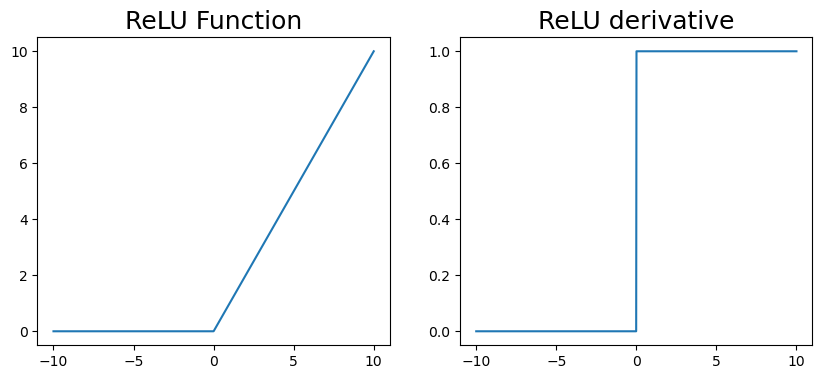

In [8]:
import matplotlib.pyplot as plt
xs = torch.linspace(-10, 10, 1000, requires_grad=True)  # 1000 evenly spaced points between -10 and 10

function_values = []
derivative_values = []

for x in xs:
    # compute function value
    y = my_relu(x)
    function_values.append(y.item())
    # compute derivative
    y_prime = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
    if y_prime is None: # PyTorch interprets `None` derivative as a zero
        y_prime = 0.0 
    derivative_values.append(y_prime)
    
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(xs.detach().numpy(), function_values)
ax[1].plot(xs.detach().numpy(), derivative_values)
ax[0].set_title('ReLU Function', fontsize=18)
ax[1].set_title('ReLU derivative', fontsize=18)
    

The ReLU function is continuous, but not differentiable at 0 because of the kink. But, it turns out that it is differentiable almost everywhere, meaning that the set of non-differentiable points is a measure zero set. 

Simply put, a function with a finite number of non-differentiable points is differentiable almost everywhere. The same holds where the number of non-differentiable points is countably infinite. 

The derivative is not defined at $0$. This is not the problem since during the course of training our parameters, we we will never hit zero (provided we initialize our parameters randomly). 

**Summary**: Automatic differentiation can handle DiffProg functions with branches as long as they are continuous and differentiable almost everywhere. 

We turn to loops next.

Consider the function $f(x, n) = \sum_{i=1}^n x^{i-1}$. For each fixed $n$, the function $f(\cdot, n)$ is a well-defined differentiable function. Therefore, we can compute $\frac{d}{dx}f(x, n)$ for *any $n$*.

This is because automatic differentiation can work with *dynamic computation graphs*, i.e., computations are specified on the fly. We do *not* need to hard-code the value of $n$ in advance.

In [9]:
def loopy_function(x, n):
    assert (0 <= x < 1).all()
    # TODO: compute f(x, n) described above
    result = 1.0
    for i in range(1, n):
        result += x**n
    return result

x = torch.rand(1, requires_grad=True)
y = loopy_function(x, 5)
y_prime = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
print(f'x: {x}, y: {y}, y_prime: {y_prime}')

y = loopy_function(x, 15)
y_prime = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
print(f'x: {x}, y: {y}, y_prime: {y_prime}')

x: tensor([0.5219], requires_grad=True), y: tensor([1.1548], grad_fn=<AddBackward0>), y_prime: tensor([1.4833])
x: tensor([0.5219], requires_grad=True), y: tensor([1.0008], grad_fn=<AddBackward0>), y_prime: tensor([0.0233])


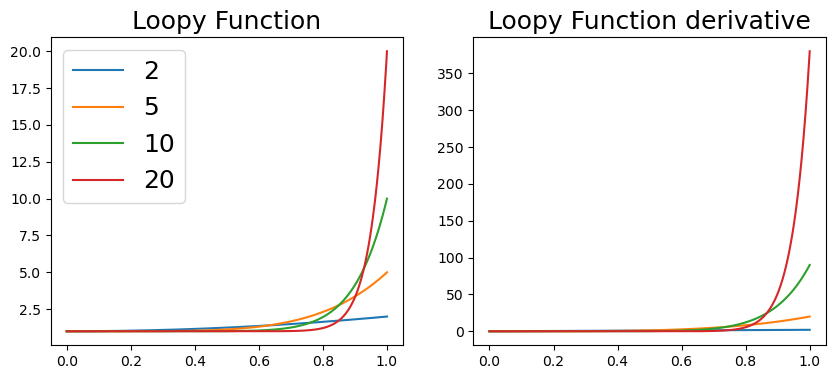

In [10]:
xs = torch.linspace(0, 0.99999, 1000, requires_grad=True)  # 1000 evenly spaced points between 0 and 1

f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title('Loopy Function', fontsize=18)
ax[1].set_title('Loopy Function derivative', fontsize=18)

for n in [2, 5, 10, 20]:
    function_values = []
    derivative_values = []
    for x in xs:
        # compute function value
        y = loopy_function(x, n)
        function_values.append(y.item())
        # compute derivative
        y_prime = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
        derivative_values.append(y_prime)

    ax[0].plot(xs.detach().numpy(), function_values, label=n)
    ax[1].plot(xs.detach().numpy(), derivative_values)
    
ax[0].legend(fontsize=18)


We will look a further look at issues arising from branching and looping in DiffProg functions in the homework. 

## Part 4: Learning rate and batch size for a convolutional neural network. 

### Convolutional neural network

A different type of neural networks appropriate for images or audio signals are called convolutional neural networks (ConvNets). It is also made up of a chain of compositions of linear operations and non-linear maps. The difference is that the linear operation is a convolution, which respects the spatial structure of the images or the temporal structure of audio. 

We will give the precise definition of ConvNets next week; for now we simply use them as just another type of a deep net.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width=500>


### Exercise: Divergent learning rates in ContNets
Now, we will try to find the divergent learning rate of the convolutional neural network.

We start with the data-loading and define write out the logging functions, as previously.
Complete the code for the SGD update.

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


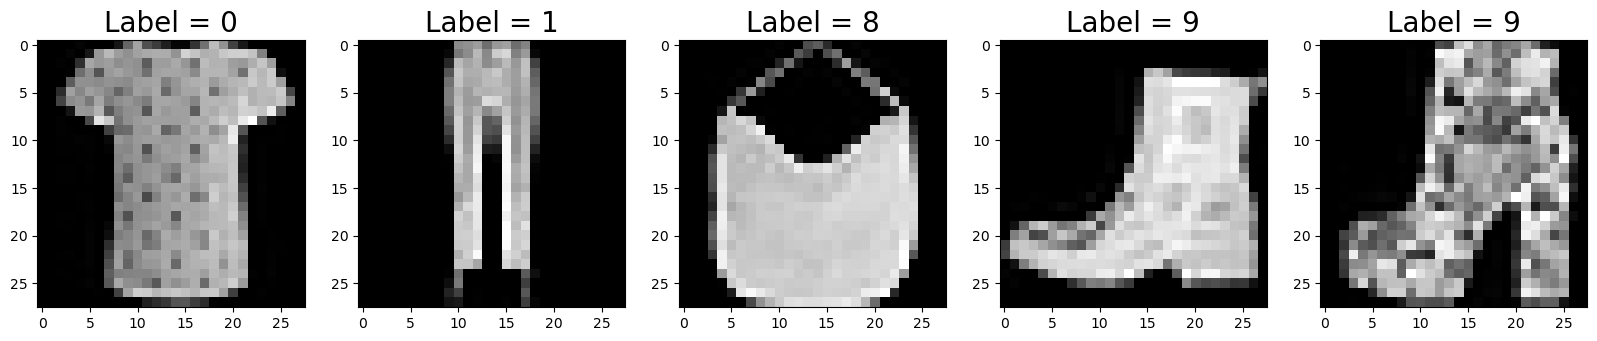

In [11]:
from torchvision.datasets import FashionMNIST
import numpy as np
import matplotlib.pyplot as plt

# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10)).long()
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
    
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

In [12]:
from torch.nn.functional import cross_entropy

def compute_objective(net, X, y):
    """ Compute the multinomial logistic loss. 
        net is a module
        X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = net(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(net, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = net(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    # Return the fraction of predictions that are correct
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(net, verbose=False):
    train_loss = compute_objective(net, X_train, y_train)
    test_loss = compute_objective(net, X_test, y_test)
    train_accuracy = compute_accuracy(net, X_train, y_train)
    test_accuracy = compute_accuracy(net, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

def minibatch_sgd_one_pass(net, X, y, learning_rate, batch_size, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        # TODO: your code here: sample `batch_size` many indices from {0, ..., num_examples-1}
        idxs = np.random.choice(num_examples, size=(batch_size,)) 
        # compute the objective. 
        objective = compute_objective(net, X[idxs], y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # TODO: your code here: compute the gradient using automatic differentiation
        # Hint: you can access the parameters of `net.parameters()`
        gradients = torch.autograd.grad(outputs=objective, inputs=net.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        # Hint: you can access the parameters of `net.parameters()`
        with torch.no_grad():
            for (w, g) in zip(net.parameters(), gradients):
                w -= learning_rate * g
    return net

We will use a ConvNet written as a PyTorch module.

In [13]:
class MyConvNet(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.fully_connected_layer = torch.nn.Linear(7*7*32, 10)
        # Note: the size 7*7*32 comes from the output size of the
        # previous layer. We will see how to find this next week.
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # reshape input; convolutions need a channel
        out = self.conv_ensemble_1(x)  # first convolution + relu + pooling
        out = self.conv_ensemble_2(out) # second convolution + relu + pooling
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out

In [14]:
learning_rate = 0.08

logs = []

model = MyConvNet(num_classes=10)
print('Iteration 0', end=', ')
logs.append(compute_logs(model, verbose=True))

batch_size = 16

for j in range(100):
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    logs.append(compute_logs(model, verbose=True))



Iteration 0, Train Loss = 2.296, Train Accuracy = 0.161, Test Loss = 2.298, Test Accuracy = 0.155
Iteration 1, Train Loss = 0.426, Train Accuracy = 0.850, Test Loss = 0.514, Test Accuracy = 0.823
Iteration 2, Train Loss = 0.322, Train Accuracy = 0.892, Test Loss = 0.457, Test Accuracy = 0.842
Iteration 3, Train Loss = 0.333, Train Accuracy = 0.884, Test Loss = 0.492, Test Accuracy = 0.837
Iteration 4, 

KeyboardInterrupt: 

**Exercise**: Run learning rates $0.01, 0.02, 0.04, 0.08$ on batch sizes $1, 4, 16, 64$ for ten epochs and note which settings lead to the smallest training error and highest test accuracy. 

Specifically, answer the following questions:

- At each batch size, which learning rate leads to the best test accuracy?
- Taking the best learning_rate for each batch size, which batch size gives the best test accuracy?

In [52]:
logs_all = {}

for batch_size in [1, 4, 16, 64]:
    for learning_rate in [0.01, 0.02, 0.04, 0.08]:
        print(f'Starting LR={learning_rate}, batch_size={batch_size}')

        logs = []

        model = MyConvNet(num_classes=10)
        print('Iteration 0', end=', ')
        logs.append(compute_logs(model, verbose=True))

        for j in range(10):
            model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
            print(f'Iteration {j+1}', end=', ')
            logs.append(compute_logs(model, verbose=True))
            
        logs_all[(learning_rate, batch_size)] = logs


Starting LR=0.01, batch_size=1
Iteration 0, Train Loss = 2.302, Train Accuracy = 0.090, Test Loss = 2.303, Test Accuracy = 0.088
Iteration 1, Train Loss = 0.455, Train Accuracy = 0.851, Test Loss = 0.557, Test Accuracy = 0.823
Iteration 2, Train Loss = 0.345, Train Accuracy = 0.881, Test Loss = 0.489, Test Accuracy = 0.832
Iteration 3, Train Loss = 0.369, Train Accuracy = 0.872, Test Loss = 0.571, Test Accuracy = 0.831
Iteration 4, Train Loss = 0.265, Train Accuracy = 0.909, Test Loss = 0.472, Test Accuracy = 0.843
Iteration 5, Train Loss = 0.252, Train Accuracy = 0.914, Test Loss = 0.537, Test Accuracy = 0.841
Iteration 6, Train Loss = 0.311, Train Accuracy = 0.892, Test Loss = 0.637, Test Accuracy = 0.818
Iteration 7, Train Loss = 0.228, Train Accuracy = 0.922, Test Loss = 0.602, Test Accuracy = 0.832
Iteration 8, Train Loss = 0.218, Train Accuracy = 0.926, Test Loss = 0.617, Test Accuracy = 0.833
Iteration 9, Train Loss = 0.176, Train Accuracy = 0.938, Test Loss = 0.590, Test Accura

Iteration 4, Train Loss = 0.586, Train Accuracy = 0.782, Test Loss = 0.647, Test Accuracy = 0.761
Iteration 5, Train Loss = 0.498, Train Accuracy = 0.825, Test Loss = 0.563, Test Accuracy = 0.801
Iteration 6, Train Loss = 0.459, Train Accuracy = 0.841, Test Loss = 0.519, Test Accuracy = 0.820
Iteration 7, Train Loss = 0.438, Train Accuracy = 0.845, Test Loss = 0.514, Test Accuracy = 0.818
Iteration 8, Train Loss = 0.404, Train Accuracy = 0.863, Test Loss = 0.488, Test Accuracy = 0.832
Iteration 9, Train Loss = 0.383, Train Accuracy = 0.868, Test Loss = 0.472, Test Accuracy = 0.836
Iteration 10, Train Loss = 0.468, Train Accuracy = 0.822, Test Loss = 0.563, Test Accuracy = 0.800
Starting LR=0.04, batch_size=1
Iteration 0, Train Loss = 2.320, Train Accuracy = 0.072, Test Loss = 2.318, Test Accuracy = 0.078
Iteration 1, Train Loss = 0.890, Train Accuracy = 0.682, Test Loss = 0.954, Test Accuracy = 0.667
Iteration 2, Train Loss = 0.907, Train Accuracy = 0.740, Test Loss = 1.010, Test Accur

Iteration 9, Train Loss = 0.153, Train Accuracy = 0.948, Test Loss = 0.570, Test Accuracy = 0.851
Iteration 10, Train Loss = 0.206, Train Accuracy = 0.930, Test Loss = 0.651, Test Accuracy = 0.839
Starting LR=0.08, batch_size=64
Iteration 0, Train Loss = 2.296, Train Accuracy = 0.109, Test Loss = 2.297, Test Accuracy = 0.109
Iteration 1, Train Loss = 0.652, Train Accuracy = 0.754, Test Loss = 0.699, Test Accuracy = 0.736
Iteration 2, Train Loss = 0.446, Train Accuracy = 0.840, Test Loss = 0.507, Test Accuracy = 0.819
Iteration 3, Train Loss = 0.430, Train Accuracy = 0.848, Test Loss = 0.522, Test Accuracy = 0.821
Iteration 4, Train Loss = 0.395, Train Accuracy = 0.857, Test Loss = 0.499, Test Accuracy = 0.818
Iteration 5, Train Loss = 0.336, Train Accuracy = 0.881, Test Loss = 0.458, Test Accuracy = 0.839
Iteration 6, Train Loss = 0.312, Train Accuracy = 0.887, Test Loss = 0.457, Test Accuracy = 0.835
Iteration 7, Train Loss = 0.311, Train Accuracy = 0.883, Test Loss = 0.486, Test Accu

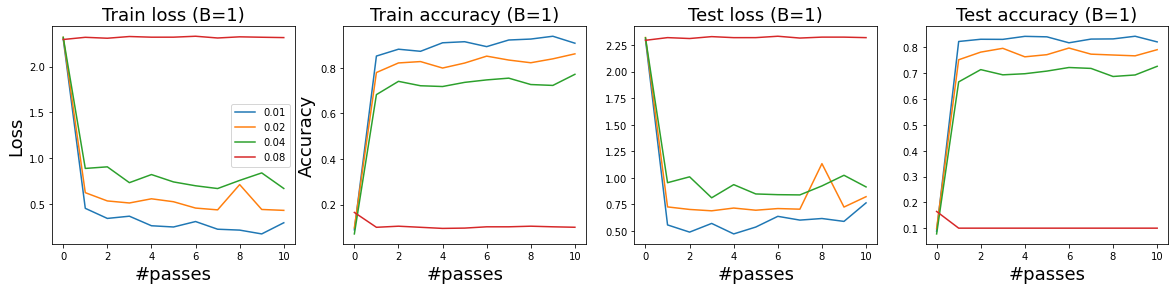

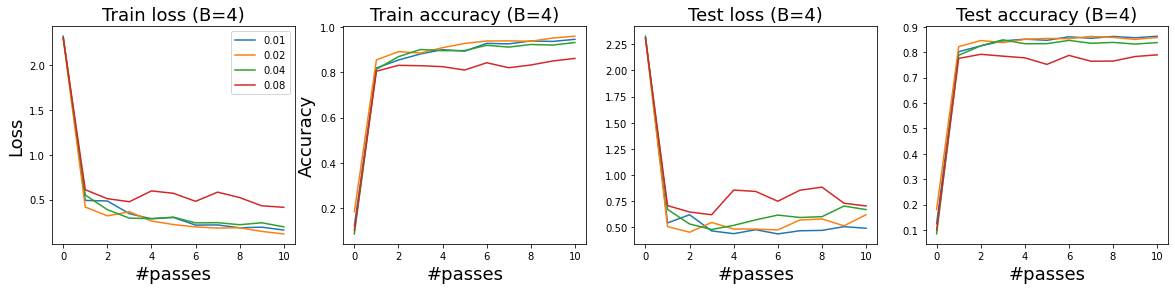

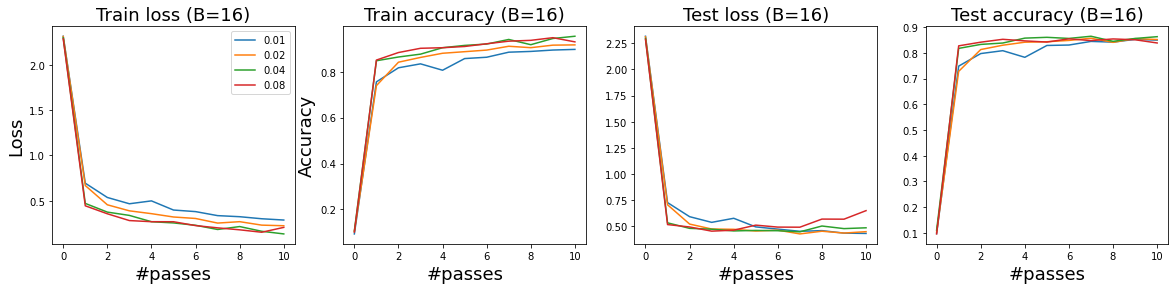

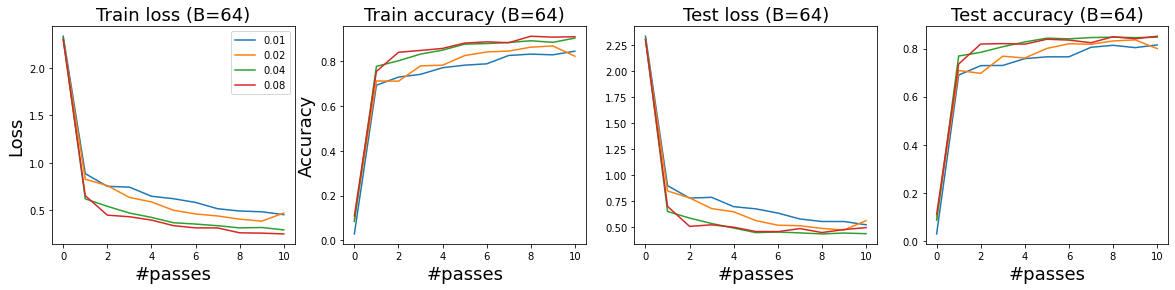

In [55]:
for batch_size in [1, 4, 16, 64]:
    f, ax = plt.subplots(1, 4, figsize=(20, 4))
    for a in ax: a.set_xlabel('#passes', fontsize=18)
    for a in [ax[0], ax[2]]: ax[0].set_ylabel('Loss', fontsize=18)
    for a in [ax[1], ax[3]]: ax[1].set_ylabel('Accuracy', fontsize=18)
    ax[0].set_title(f'Train loss (B={batch_size})', fontsize=18)
    ax[1].set_title(f'Train accuracy (B={batch_size})', fontsize=18)
    ax[2].set_title(f'Test loss (B={batch_size})', fontsize=18)
    ax[3].set_title(f'Test accuracy (B={batch_size})', fontsize=18)
    for learning_rate in [0.01, 0.02, 0.04, 0.08]:
        logs = np.asarray(logs_all[(learning_rate, batch_size)])
        ax[0].plot(logs[:, 0], label=learning_rate)
        ax[1].plot(logs[:, 1], label=learning_rate)
        ax[2].plot(logs[:, 2], label=learning_rate)
        ax[3].plot(logs[:, 3], label=learning_rate)
    ax[0].legend()
